# Dataset auto-labelling

Goals:
* label and exclude some hard-to-learn sounds
* other?

---

# Harmonic / Percussive / Other labels

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 120  # No widget
#%matplotlib widget
import librosa
import librosa.display
import librosa.decompose
import librosa.core
import importlib
import warnings
from IPython.display import Audio

import config
import data.dataset
    
def reload_config_complete_dataset():
    importlib.reload(config)
    config.model.dataset_synth_args = (None, None)  # All algorithms and operators
    config.model.dataset_labels = None  # All labels

reload_config_complete_dataset()

# fft parameters - unused? It is much easier to use librosa's defaults...
n_fft = 1024
fft_hop = 256
Fs = 22050

# Dataset spectrogram won't be used here
dataset = data.dataset.DexedDataset(** data.dataset.model_config_to_dataset_kwargs(config.model))
print(dataset)
preset_UIDs = dataset.valid_preset_UIDs

Dataset of 30293/30293 Dexed presets. 144 learnable synth params, 11 fixed params. Mel Spectrogram items, size=torch.Size([1, 257, 347]), min=-120.0dB, normalization:min_max. Restricted to labels: None. Enabled algorithms: all. Enabled operators: [1, 2, 3, 4, 5, 6]


## Critères de séparation
Pour les sons de synthé bien harmoniques, aucun problème, le spectre de puissance harmonique (margin 3.0) contient bien >98% de la puissance spectrale totale.
Attention par contre, on peut descendre à - de 50% d'énergie harmonique pour des synthés à forte attaque (type percu). Mais on a alors pas beaucoup de résidus.

Pour des sons identifiés comme harmoniques "qui partent en sucette", ça va être dûr.

Pour des sons SFX avec des composantes harmonique aléatoires : 
* **TODO voir si les raies principales correspondent à la note jouée** (pitch tracking)

Pour des sons SFX n'imp :
* Spectral flatness?
* Pas d'harmoniques faciles à détecter?
* Pas de pitch clair?

* Sons harmoniques mais qui partent en sucette :
    * 3104 (64% res), 3011
    * 5760
    * 7909
    * 31421 (65% harm mais pitch descend très bas)
    * 71706 (quasi-séquence) (56% perc)
    * 75897 (vibrato 12%;29% compté en perc;res)
* Sons harmoniques qui partent en sucette au release :
    * 5833 (22% de résidu, quasi-tout au release)
* SFX, sons intéressants mais pas harmoniques (pourraient aider le NN à bien comprendre comment fonctionne Dexed ?)
    * 2520, 2522 (68% perc)
    * 3067
    * 3103, 3105, 3107, 3109, 3110, 3112, 3115, 3116, 3118, ... (pas mal de résidus, perc pour certains)
    * 4200 (rés 62%)
    * 7059
    * 7893
    * 8123
    * 22468
    * 54099
    * 71949
    * 73029 (36/24/40 %)
    * 75989
    * 76103, 76105
    * 78064
    * 203867
    * 245768
* Kicks / percus (idem, peut-être intéressants)
    * 81538 (77% perc)
    * 246879 (95% prec)
* Presque zéro :
    * 2555 (96% harmonique mais à 20Hz)
    * 54035 (100% perc)
* Gros n'imp, limite inécoutable :
    * 3111 (10% harm)
    * 71429 (29% harm)
    * 74146 (12/17/71 %)
    * 75334 (11/11/78 %), 75340 (10/20/70%)
    * 78256 (40/7/54 % mais harmoniques dégueu)
    * 78707 (10/31/59 %)
    * 81660 (12/24/64 %), 81662 (9/16/75 %, sinus dégueu pas compté en harmonique), 81664 (9/20/71 %), ...
    * 171019 (22/74/4 %, sinus sur-aigu pas compté en harmonique)
    
Après labels harmonic, certains sons harmoniques ne sont pas au pitch midi note 60:
* 80854 (sur-aigu)

/home/gwendal/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/gwendal/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/gwendal/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


is_harmonic=True   is_percussive=False
attack energies = {'D': 6812.647857516567, 'H': 5258.100787591085, 'P': 857.3462747562944, 'R': 697.2007951691869}
Original audio, preset UID=55290


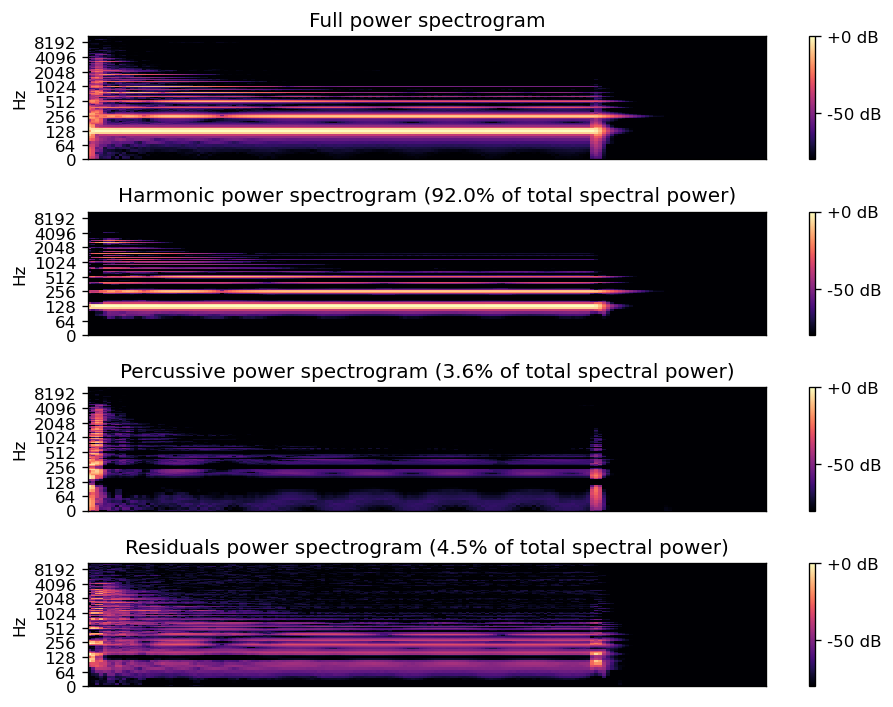

In [9]:
# - - - - - - - - - - - - - - - - - - - - - - - -
preset_index = np.random.randint(0, len(preset_UIDs))
preset_UID = preset_UIDs[preset_index]
#preset_UID =  75011 # possible d'entrer direct un UID ici - commenter sinon
# - - - - - - - - - - - - - - - - - - - - - - - -
# Test on 1 sample: harmonic/percussive source separation
x_wav, Fs = dataset._get_wav_file(preset_UID)

import utils.audio
importlib.reload(utils.audio)
sample_labeler = utils.audio.SimpleSampleLabeler(x_wav, Fs, hpss_margin=3.0)
sample_labeler.plot_hpr_specs()

sample_labeler.print_labels()

print("attack energies = {}".format(sample_labeler.attack_energies))

print("Original audio, preset UID={}".format(preset_UID))
Audio(x_wav, rate=Fs)

In [10]:
print("Harmonic content")
Audio(sample_labeler.get_harmonic_sound(), rate=Fs)

Harmonic content


In [11]:
print("Percussive content")
Audio(sample_labeler.get_percussive_sound(), rate=Fs)

Percussive content


In [12]:
print("Residual content")
Audio(sample_labeler.get_residual_sound(), rate=Fs)

Residual content


---
## Exemples d'auto-labelling

Original audio, preset UID=3940
is_harmonic=False   is_percussive=True


/home/gwendal/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/gwendal/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/gwendal/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


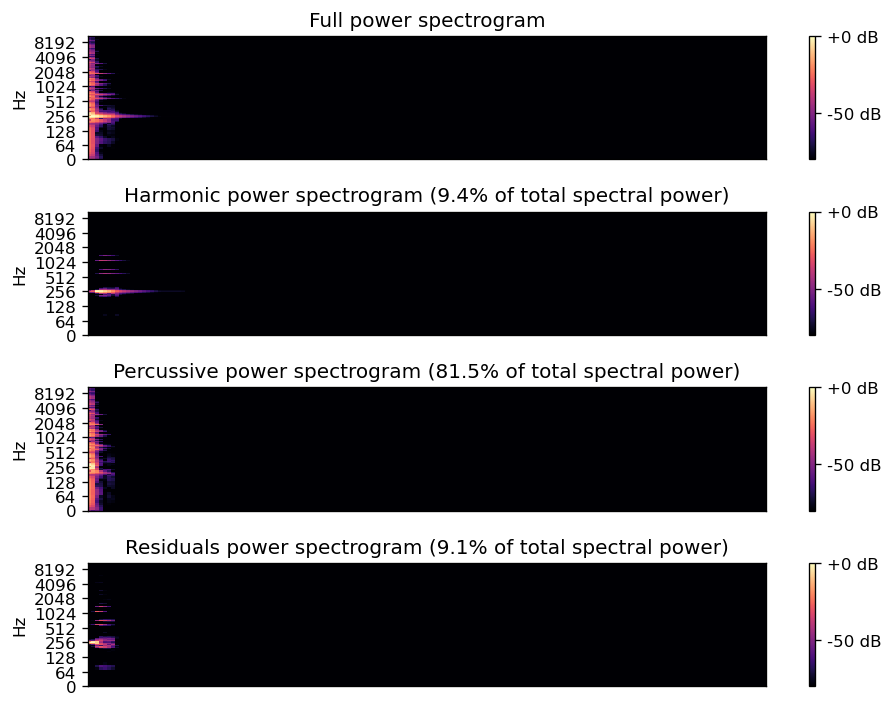

In [6]:
importlib.reload(utils.audio)

found = False
while not found:
    # - - - - - - - - - - - - - - - - - - - - - - - -
    preset_index = np.random.randint(0, len(dataset))
    preset_UID = preset_UIDs[preset_index]
    #preset_UID = 28  # possible d'entrer direct un UID ici - commenter sinon
    # - - - - - - - - - - - - - - - - - - - - - - - -
    # Test on 1 sample: harmonic/percussive source separation
    x_wav, Fs = dataset._get_wav_file(preset_UID)
    sample_labeler = utils.audio.SimpleSampleLabeler(x_wav, Fs, hpss_margin=3.0)
    
    # comment/uncomment following lines to get a sample by label (or combination of labels)
    #found = sample_labeler.is_percussive()
    found = sample_labeler.is_percussive and not sample_labeler.is_harmonic


print("Original audio, preset UID={}".format(preset_UID))
sample_labeler.print_labels()
sample_labeler.plot_hpr_specs()

Audio(x_wav, rate=Fs)

In [ ]:
# Full dataset labelling - very long computation (single-threaded)
importlib.reload(utils.audio)
nb = {'harmonic': 0, 'percussive': 0, 'sfx': 0}
if True:
    for preset_index in range(len(dataset)):
        x_wav, Fs = dataset._get_wav_file(preset_UIDs[preset_index])
        sample_labeler = utils.audio.SimpleSampleLabeler(x_wav, Fs, hpss_margin=3.0)
        for k in nb:
            nb[k] += 1 if sample_labeler.has_label(k) else 0
        if preset_index % 1000 == 0:
            print(nb)
            if preset_index > 0:
                break
nb

In [14]:
# =========================================================
# =========================================================
# ============== Labels multiproc. computation ============
# ============ Audio files must be pre-rendered ===========
# =========================================================
# =========================================================
import utils.audio
importlib.reload(utils.audio)
import time
import os
import numpy as np
import multiprocessing
import soundfile

def get_presets_labels(preset_UIDs):
    """ Returns a list of labels (list of list of strings) for all given preset_UIDs.
        Wav files path is hardcoded in this function (easier dirty multiprocessing). """
    labels = []
    for i in range(len(preset_UIDs)):
        preset_UID = preset_UIDs[i]
        x_wav, Fs = soundfile.read("synth/dexed_presets/preset{:06d}_midi060vel100.wav".format(preset_UID))
        sample_labeler = utils.audio.SimpleSampleLabeler(x_wav, Fs)
        labels.append([])
        for l in ['harmonic', 'percussive', 'sfx']:
            if sample_labeler.has_label(l):
                labels[-1].append(l)
    return labels

t0 = time.time()
# Multi-processed labeling (> 150ms/preset on 1 CPU)
# not need to try  cpucount// 2 (hyperthreading does not lower perf.)
num_workers = np.minimum(len(dataset.valid_preset_UIDs), os.cpu_count())  # security for very small datasets... quite useless
# Distribute presets over workers 
UIDs_array = np.asarray(dataset.valid_preset_UIDs)
presets_per_worker = len(dataset.valid_preset_UIDs) // num_workers
distributed_UIDs = [UIDs_array[i*presets_per_worker : (i+1)*presets_per_worker] for i in range(num_workers - 1)]
# last worker might get more presets to process
distributed_UIDs.append(UIDs_array[(num_workers-1)*presets_per_worker : ])
# length test
assert sum([len(u) for u in distributed_UIDs]) == len(dataset.valid_preset_UIDs)
print("Presets count per worker = {}".format([len(u) for u in distributed_UIDs]))

with multiprocessing.Pool(num_workers) as p:
    distributed_labels = p.map(get_presets_labels, distributed_UIDs)

print("labels computed, {:.1f}ms / preset ({:.0f}s total)".format(1000.0 * (time.time() - t0) / len(dataset.valid_preset_UIDs), (time.time() - t0)))

Presets count per worker = [631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 636]


/home/gwendal/Jupyter/nn-synth-interp/utils/audio.py:136: RuntimeWarning: invalid value encountered in double_scalars
  return energy, {'D': 1.0, 'H': energy['H'] / energy['D'], 'P': energy['P'] / energy['D'],
/home/gwendal/Jupyter/nn-synth-interp/utils/audio.py:137: RuntimeWarning: invalid value encountered in double_scalars
  'R': energy['R'] / energy['D']}


labels computed, 4.5ms / preset (136s total)


In [21]:
labels = sum(distributed_labels, [])  # List sum performs a "squeeze"
labels_counts = {'harmonic': 0, 'percussive': 0, 'sfx': 0}
for _, labels_list in enumerate(labels):
    for k in labels_counts:
        if k in labels_list:
            labels_counts[k] += 1
print("Labelled {} audio samples".format(len(labels)))
labels_counts

Labelled 30293 audio samples


{'harmonic': 27511, 'percussive': 1560, 'sfx': 1618}

In [9]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!! DANGER ZONE !!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
if False:
    import sqlite3
    conn = sqlite3.connect('./synth/dexed_presets.sqlite', detect_types=sqlite3.PARSE_DECLTYPES)
    cur = conn.cursor()
    # Write labels to SQLite database
    # column 'labels' has already been inserted (from sqlite db browser)
    # TODO add labels are comma-separated text values
    for i in range(len(dataset.valid_preset_UIDs)):
        preset_UID = dataset.valid_preset_UIDs[i]
        preset_labels = ','.join(labels[i])  # 1 comma-separated string
        cur.execute("UPDATE preset SET labels='{}' WHERE index_preset={};".format(preset_labels, preset_UID))

    conn.commit()
    conn.close()
    print("Labels written to SQLite database")

27411

---
## Pitch analysis
todo...

In [10]:
# Pitch?
pitches, magnitudes = librosa.core.piptrack(S=sample_labeler.specs['H'], fmin=150, fmax=4e3)

# TODOOOO les pitches! sur les 3 secondes où la note joue

# On peut prendre les 100 + basses fréquences (ça va déjà jusqu'à quasi 1kHz)
plt.figure(figsize=(8, 6))  
plt.subplot(2, 1, 1)
plt.imshow(pitches[:100, :], aspect="auto", interpolation="nearest", origin='lower')
plt.subplot(2, 1, 2)
plt.imshow(magnitudes[:100, :], aspect="auto", interpolation="nearest", origin='lower')
plt.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …